### Introduzione al Codice
Questo codice implementa un workflow completo per la classificazione di un dataset di giocatori NBA, identificando il tipo di giocatore come target. Il processo comprende la preparazione dei dati, il bilanciamento delle classi tramite SMOTE, la costruzione e ottimizzazione di modelli di machine learning (Random Forest e Logistic Regression), e l'analisi dei risultati. Include anche visualizzazioni chiave come le matrici di confusione, curve ROC, e l'importanza delle feature. Il codice si presta per una pipeline end-to-end, utile per analisi predittive e decisioni data-driven.

#### installazione delle librerie necessarie
Installa le librerie principali necessarie per il progetto.

**pandas**: Per la manipolazione e analisi dei dati.  
**scikit-learn**: Per la costruzione, addestramento e valutazione dei modelli di machine learning.  
**imbalanced-learn**: Per la gestione di dataset sbilanciati (include SMOTE).  
**matplotlib e seaborn**: Per creare visualizzazioni e grafici.  

In [13]:
!pip install pandas scikit-learn imbalanced-learn matplotlib seaborn   

#### Importazione delle librerie
Importa tutte le librerie richieste per il pre-processing, bilanciamento delle classi, costruzione dei modelli, visualizzazioni e metriche di valutazione.

In [14]:
# Importazione delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

#### Caricamento e pre-processing del dataset
Carica il dataset, rimuove le colonne irrilevanti, elimina righe con valori mancanti, e separa le feature dal target.

In [15]:

# Caricamento del dataset
df = pd.read_csv('nba_data.csv')

# Rimozione di colonne non necessarie per l'analisi
df.drop(["PLAYER_ID", "PLAYER_NAME", "SEASON_YEAR"], axis=1, inplace=True)

# Rimozione delle righe con valori mancanti
df.dropna(inplace=True)

# Separazione delle variabili indipendenti (features) e dipendenti (target)
X = df.drop(columns=['player_type'])
y = df['player_type']

# Visualizzazione dei primi record per verificare i dati
df.head()

,TOTAL_MIN,TOTAL_GAMES,AVG_MIN,FGM,FGA,FG_PCT,FGM_PER_GAME,FGA_PER_GAME,FGM2,FG2A,...,STL,BLK,STL_PER_GAME,BLK_PER_GAME,PF,PF_PER_GAME,PTS,PTS_PER_GAME,PLUS_MINUS,player_type
0,15138,545,27.776147,3394,7697.0,0.440951,6.227523,14.122936,2924.0,6372.0,...,478.0,45.0,0.877064,0.082569,1056.0,1.937615,8287,15.205505,-219,5
1,4804,236,20.355932,720,1726.0,0.417149,3.050847,7.313559,702.0,1650.0,...,184.0,83.0,0.779661,0.351695,485.0,2.055085,1830,7.754237,-406,7
2,28849,824,35.010922,5431,11501.0,0.472220,6.591019,13.957524,5277.0,10982.0,...,819.0,638.0,0.993932,0.774272,2315.0,2.809466,15018,18.225728,-2895,5
3,4642,291,15.951890,571,1459.0,0.391364,1.962199,5.013746,342.0,809.0,...,254.0,36.0,0.872852,0.123711,485.0,1.666667,1628,5.594502,-520,7
4,4061,187,21.716578,655,1552.0,0.422036,3.502674,8.299465,614.0,1431.0,...,111.0,18.0,0.593583,0.096257,377.0,2.016043,1690,9.037433,-464,7


#### Analisi della distribuzione delle classi
Mostra la distribuzione iniziale delle classi del target (**`player_type`**).

In [16]:
# Analisi della distribuzione iniziale delle classi
print("\nDistribuzione delle classi iniziali:")
print(y.value_counts())



Distribuzione delle classi iniziali:
player_type
7    1275
5     464
4     239
2     227
6     209
1      95
3      30
Name: count, dtype: int64


#### Suddivisione in training e test set
Divide i dati in training e test set (70/30) mantenendo la proporzione delle classi.

In [17]:
# Divisione dei dati in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Analisi della distribuzione dopo la suddivisione
print("\nDistribuzione delle classi nel set di training:")
print(y_train.value_counts())
print("\nDistribuzione delle classi nel set di test:")
print(y_test.value_counts())



Distribuzione delle classi nel set di training:
player_type
7    892
5    325
4    167
2    159
6    146
1     67
3     21
Name: count, dtype: int64

Distribuzione delle classi nel set di test:
player_type
7    383
5    139
4     72
2     68
6     63
1     28
3      9
Name: count, dtype: int64


#### Bilanciamento delle classi con SMOTE
Applica SMOTE per bilanciare il dataset di addestramento, aumentando le minoranze.

In [18]:
# Applicazione di SMOTE per bilanciare il dataset di addestramento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Analisi della distribuzione dopo SMOTE
print("\nDistribuzione delle classi nel set di training dopo SMOTE:")
print(y_train_res.value_counts())



Distribuzione delle classi nel set di training dopo SMOTE:
player_type
1    892
7    892
4    892
6    892
5    892
3    892
2    892
Name: count, dtype: int64


#### Configurazione dei modelli e ricerca iperparametrica
Configura i modelli (Random Forest e Logistic Regression) e i rispettivi spazi di ricerca per l'ottimizzazione iperparametrica.

In [19]:
# Creazione del dizionario dei modelli da allenare
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear', max_iter=500)
}

# Parametri per la ricerca iperparametrica tramite GridSearchCV
param_grid = {
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None],
    },
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    }
}

#### Addestramento e valutazione dei modelli
Esegue la ricerca iperparametrica, addestra i modelli con i migliori parametri e valuta le loro performance sul test set.

In [20]:
# Liste per memorizzare risultati e modelli
results = {}
best_models = {}

# Ciclo per allenare e valutare ogni modello
for model_name, model in models.items():
    print(f"\nInizio allenamento del modello {model_name}...")
    
    # Ricerca dei migliori iperparametri con validazione incrociata
    grid_search = GridSearchCV(model, param_grid[model_name], cv=3, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)  
    
    # Estrazione del modello con migliori parametri
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    print(f"Miglior modello per {model_name}: {grid_search.best_params_}")
    
    # Predizione sui dati di test
    y_pred = best_model.predict(X_test)
    
    # Stampa dei risultati di classificazione
    print(f"Risultati per {model_name}:\n")
    print(classification_report(y_test, y_pred))
    
    # Matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    results[model_name] = {"y_pred": y_pred, "confusion_matrix": cm}



Inizio allenamento del modello Random Forest...
Miglior modello per Random Forest: {'max_depth': 20, 'n_estimators': 100}
Risultati per Random Forest:

              precision    recall  f1-score   support

           1       0.86      0.89      0.88        28
           2       0.97      0.82      0.89        68
           3       0.60      0.67      0.63         9
           4       0.92      0.97      0.95        72
           5       0.83      0.82      0.83       139
           6       0.81      0.83      0.82        63
           7       0.98      0.99      0.99       383

    accuracy                           0.92       762
   macro avg       0.85      0.86      0.85       762
weighted avg       0.92      0.92      0.92       762


Inizio allenamento del modello Logistic Regression...
Miglior modello per Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Risultati per Logistic Regression:

              precision    recall  f1-score   support

           1       0.41      0

#### Visualizzazione delle matrici di confusione
Visualizza le matrici di confusione per ogni modello con annotazioni dettagliate.

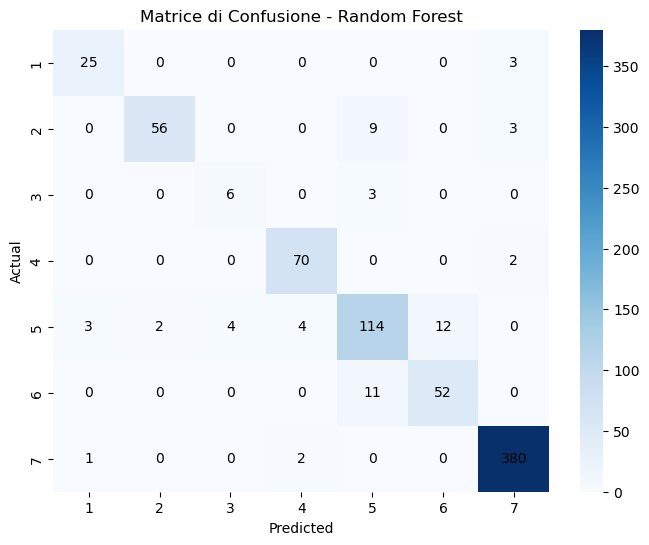

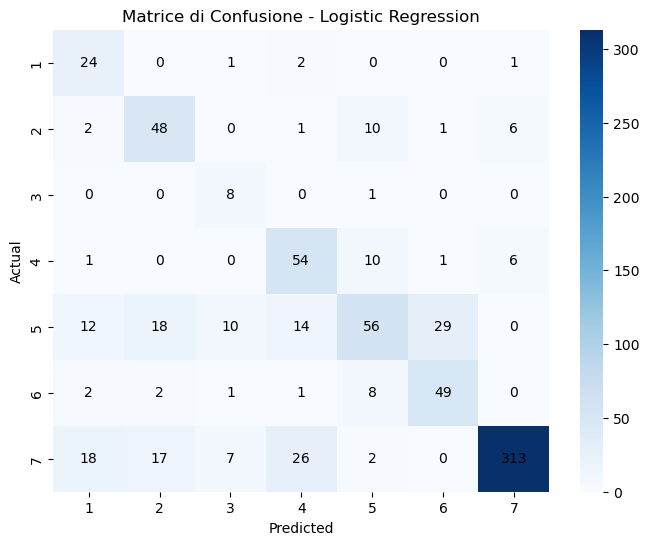

In [21]:
# Assicurati che la matrice di confusione abbia la forma giusta
rf_cm = results["Random Forest"]["confusion_matrix"]
lr_cm = results["Logistic Regression"]["confusion_matrix"]

# Ordina le etichette delle classi in ordine crescente
ordered_labels = sorted(y.unique())

# Visualizzazione della matrice di confusione per Random Forest
plt.figure(figsize=(8, 6))
ax = sns.heatmap(rf_cm, cmap="Blues", xticklabels=ordered_labels, yticklabels=ordered_labels, cbar=True, fmt="d")

# Annotazione manuale delle celle
for i in range(rf_cm.shape[0]):
    for j in range(rf_cm.shape[1]):
        ax.text(j + 0.5, i + 0.5, rf_cm[i, j], ha="center", va="center", color="black")

plt.title('Matrice di Confusione - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualizzazione della matrice di confusione per Logistic Regression
plt.figure(figsize=(8, 6))
ax = sns.heatmap(lr_cm, cmap="Blues", xticklabels=ordered_labels, yticklabels=ordered_labels, cbar=True, fmt="d")

# Annotazione manuale delle celle
for i in range(lr_cm.shape[0]):
    for j in range(lr_cm.shape[1]):
        ax.text(j + 0.5, i + 0.5, lr_cm[i, j], ha="center", va="center", color="black")

plt.title('Matrice di Confusione - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### Curve ROC multiclasse

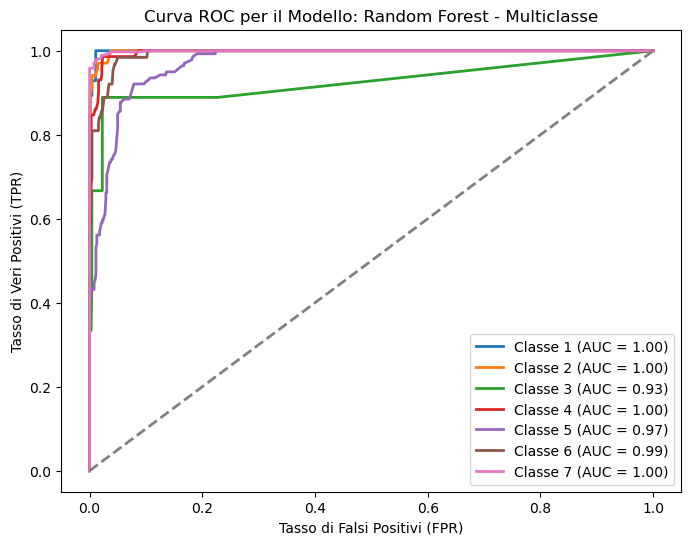

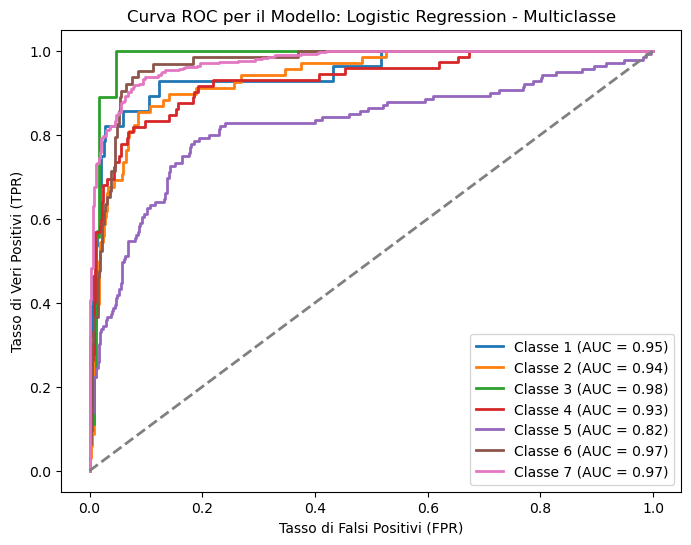

In [22]:
import warnings
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model_name, y_true, y_pred_proba, num_classes):
    """
    Visualizza la curva ROC per ciascuna classe in un problema di classificazione multiclasse.

    Parameters:
    - model_name: Nome del modello da visualizzare.
    - y_true: Etichette vere del set di test.
    - y_pred_proba: Probabilità previste per ciascuna classe.
    - num_classes: Numero totale di classi nel dataset.
    """
    # Binarizzazione delle etichette per il calcolo della ROC per ciascuna classe
    y_true_bin = label_binarize(y_true, classes=np.arange(1, num_classes + 1))  # Le etichette sono da 1 a 7
    
    # Variabili per raccogliere i valori di ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Sopprimere il warning UndefinedMetricWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)  # Filtra gli avvisi di tipo UserWarning
        # Calcolo ROC per ogni classe
        for i in range(num_classes):
            try:
                fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            except ValueError:
                # In caso di errore (ad esempio, classe vuota), omettiamo la classe
                print(f"Classe {i + 1} assente nel set di test. Saltando...")
                continue

    # Plot delle curve ROC per tutte le classi
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        if i in roc_auc:  # Aggiungi solo le classi che hanno una curva ROC calcolata
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {i + 1} (AUC = {roc_auc[i]:.2f})')

    # Linea diagonale (caso random)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.title(f"Curva ROC per il Modello: {model_name} - Multiclasse")
    plt.xlabel("Tasso di Falsi Positivi (FPR)")
    plt.ylabel("Tasso di Veri Positivi (TPR)")
    plt.legend(loc="lower right")
    plt.show()

# Predizioni probabilistiche per Random Forest e Logistic Regression
y_pred_proba_rf = best_models["Random Forest"].predict_proba(X_test)
y_pred_proba_lr = best_models["Logistic Regression"].predict_proba(X_test)

# Usa questa funzione per ciascun modello (presumendo che il numero di classi sia 7)
num_classes = 7  # Numero di classi (1 a 7)
plot_multiclass_roc("Random Forest", y_test, y_pred_proba_rf, num_classes)
plot_multiclass_roc("Logistic Regression", y_test, y_pred_proba_lr, num_classes)


La Curva ROC è un grafico che visualizza le prestazioni di un modello di classificazione mostrando il compromesso tra il tasso di veri positivi (TPR) e il tasso di falsi positivi (FPR) a diverse soglie decisionali. Per un modello ideale, la curva si avvicina all'angolo in alto a sinistra, indicando una classificazione quasi perfetta. L'area sotto la curva (AUC) fornisce una misura complessiva delle prestazioni: maggiore è l'AUC, migliore è il modello. In un problema multiclasse, la curva ROC viene calcolata separatamente per ogni classe rispetto a tutte le altre.





#### Importanza delle Feature - Random Forest
Questa cella visualizza quanto ciascuna feature contribuisce alle predizioni del modello Random Forest. Viene calcolata l'importanza delle feature utilizzando l'attributo **`feature_importances_`** del modello. Le feature vengono ordinate per importanza decrescente e rappresentate tramite un grafico a barre orizzontali, consentendo di identificare le variabili più influenti nel modello.

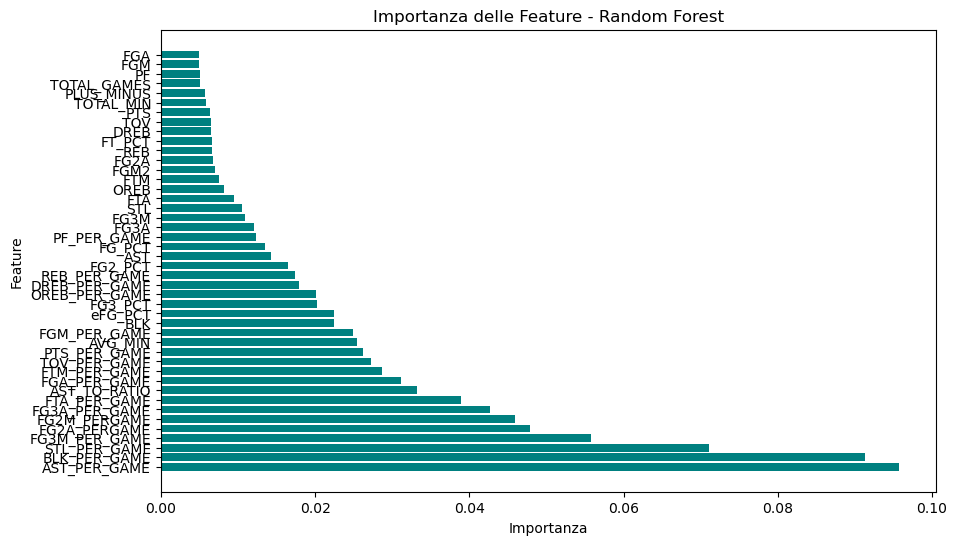

In [23]:
#Visualizza l'importanza delle feature nel modello Random Forest.
def plot_feature_importance(model, X):

    importance = model.feature_importances_
    feature_names = X.columns
    
    # Ordina per importanza
    sorted_idx = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx], importance[sorted_idx], color="teal")
    plt.title("Importanza delle Feature - Random Forest")
    plt.xlabel("Importanza")
    plt.ylabel("Feature")
    plt.show()

# Usa questa funzione per il modello Random Forest
plot_feature_importance(best_models["Random Forest"], X_train_res)


#### Matrice di Correlazione delle Feature
Questa cella mostra la matrice di correlazione delle feature del dataset. La matrice evidenzia la relazione tra le variabili tramite il coefficiente di correlazione, visualizzato con una heatmap. Le annotazioni indicano i valori numerici della correlazione, con tonalità di colore che vanno da rosso/blu scuro (correlazione negativa) a rosso/blu chiaro (correlazione positiva). Questo aiuta a identificare possibili relazioni forti o ridondanze tra le variabili.

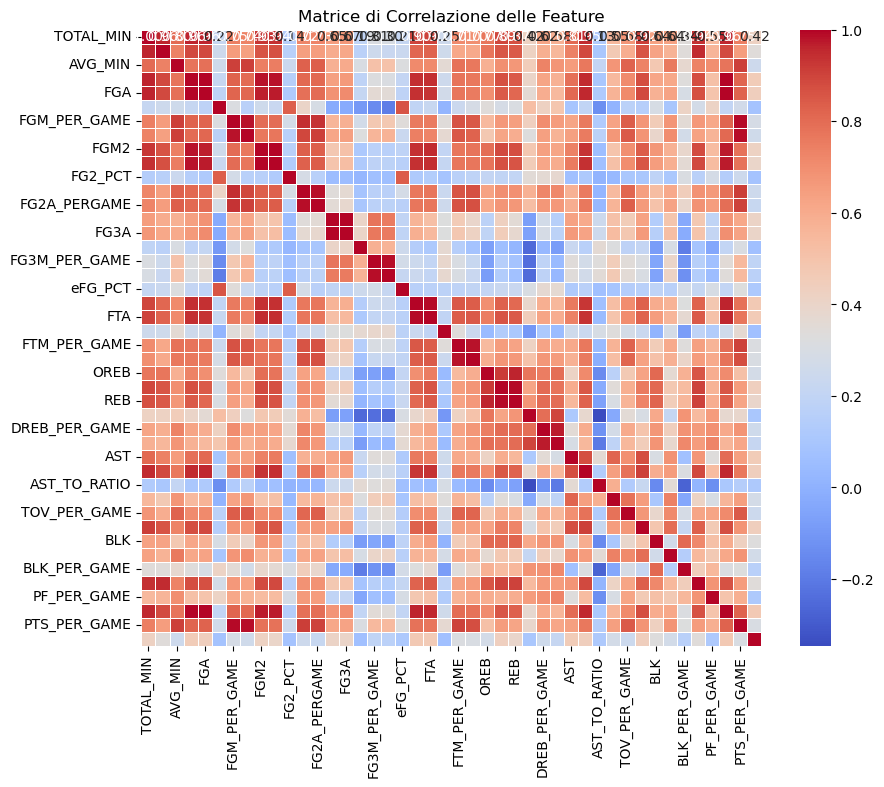

In [24]:
# Visualizza la matrice di correlazione per il set di feature X
def plot_feature_correlation(X):
    
    plt.figure(figsize=(10, 8))
    corr_matrix = X.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title('Matrice di Correlazione delle Feature')
    plt.show()
plot_feature_correlation(X)

